In [207]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import joblib

In [153]:
df_train = pd.read_csv("..\\Datasets\\Final_Training_set.csv")
df_test = pd.read_csv("..\\Datasets\\Final_Test_set.csv")

In [154]:
X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)

y_train = df_train['price']
y_test = df_test['price']

In [155]:
kf = 10

In [156]:
def analyze_importance_distribution(series, threshold=0.8, plot=True, normalize=True):
    freq = series.sort_values(ascending=False)
    if normalize:
        freq = freq / freq.sum()
    
    cum_freq = freq.cumsum()
    
    summary_df = pd.DataFrame({
        'importance': freq,
        'cumulative': cum_freq
    })

    lorenz_y = np.insert(np.cumsum(np.sort(freq.values)), 0, 0)
    lorenz_y = lorenz_y / lorenz_y[-1]
    lorenz_x = np.linspace(0, 1, len(lorenz_y))
    gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,6))
        plt.plot(lorenz_x, lorenz_y, label='Lorenz Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Line of Equality')
        plt.title('Lorenz Curve of Feature Importances')
        plt.xlabel('Cumulative Share of Features')
        plt.ylabel('Cumulative Share of Importance')
        plt.grid(True)
        plt.legend()
        plt.text(0.05, 0.8, f'Gini Coefficient: {gini:.4f}', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        plt.show()

    top_features = summary_df[summary_df['cumulative'] <= threshold].index.tolist()

    print(f"Top features (cover {threshold*100}%):")
    for f in top_features:
        print(f" - {f} (importance = {summary_df.loc[f, 'importance']:.4f})")

    return {
        'summary_df': summary_df,
        'top_features': top_features,
        'gini_coefficient': gini
    }


In [157]:
original_y_train = np.expm1(y_train)
original_y_test = np.expm1(y_test)

# 1. Linear Regression

In [159]:
linear_model = LinearRegression() 

In [160]:
linear_cv = cross_val_predict(linear_model, X_train, y_train, cv=kf)

linear_cv_r2 = r2_score(original_y_train, np.expm1(linear_cv))
linear_cv_mae = mean_absolute_error(original_y_train, np.expm1(linear_cv))
linear_cv_mse = mean_squared_error(original_y_train, np.expm1(linear_cv))
linear_cv_rmse = np.sqrt(linear_cv_mse)

In [161]:
pd.DataFrame({
    'R2': linear_cv_r2,
    'MAE': linear_cv_mae,
    'MSE': linear_cv_mse,
    'RMSE': linear_cv_rmse
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.020916,1.494041e+06,1.197321e+15,3.460233e+07


### We cannot use linear model for this dataset since in data analysis step we can see that, the features do not have a strong linear relationship with the target variable

# 2. KNN Regression

In [162]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_r2 = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='r2')
KNN_grid_r2.fit(X_train, y_train)
KNN_best_model_r2 = KNN_grid.best_estimator_

In [163]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_mae = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='neg_mean_absolute_error')
KNN_grid_mae.fit(X_train, y_train)
KNN_best_model_mae = KNN_grid.best_estimator_

In [164]:
KNN_model = KNeighborsRegressor()
KNN_params = {
    'n_neighbors': [3, 5, 7, 9, 11,13,15,17,19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

KNN_grid_mse = GridSearchCV(KNN_model, KNN_params, cv=kf, scoring='neg_mean_squared_error')
KNN_grid_mse.fit(X_train, y_train)
KNN_best_model_mse = KNN_grid.best_estimator_

In [165]:
print("best model using r2 score",KNN_grid_r2.best_params_)
print("best model using mae",KNN_grid_mae.best_params_)
print("best model using mse",KNN_grid_mse.best_params_)

best model using r2 score {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
best model using mae {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
best model using mse {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}


In [167]:
KNN_best_models = {
    "r2_model": KNeighborsRegressor(n_neighbors=19, p=1, weights='uniform'),
    "mae_model": KNeighborsRegressor(n_neighbors=9, p=1, weights='distance'),
    "mse_model": KNeighborsRegressor(n_neighbors=11, p=2, weights='uniform'),
}

for name, model in KNN_best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_original = np.expm1(y_pred)

    r2 = r2_score(original_y_test, y_pred_original)
    mae = mean_absolute_error(original_y_test, y_pred_original)
    mse = mean_squared_error(original_y_test, y_pred_original)
    rmse = np.sqrt(mse)

    print(f"{name}:")
    print(f"  R²    = {r2:.4f}")
    print(f"  MAE   = {mae:.4f}")
    print(f"  MSE   = {mse:.4f}")
    print(f"  RMSE  = {rmse:.4f}")
    print("-" * 30)


r2_model:
  R²    = 0.4048
  MAE   = 892221.2966
  MSE   = 14997152954428.0762
  RMSE  = 3872615.7768
------------------------------
mae_model:
  R²    = 0.4697
  MAE   = 832445.0569
  MSE   = 13360456391999.1504
  RMSE  = 3655195.8076
------------------------------
mse_model:
  R²    = 0.4737
  MAE   = 873479.6151
  MSE   = 13258806012123.1426
  RMSE  = 3641264.3425
------------------------------


# 3. Random Forest and Feature Selection using Feature Importance

In [168]:
random_forest_model = RandomForestRegressor()

random_forest_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [169]:
random_forest_random_r2 = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='r2', n_iter=20)
random_forest_random_r2.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='r2')

In [170]:
rf_best_model_r2 = random_forest_random_r2.best_estimator_

In [171]:
random_forest_random_mae = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='neg_mean_absolute_error', n_iter=20)
random_forest_random_mae.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='neg_mean_absolute_error')

In [172]:
rf_best_model_mae = random_forest_random_mae.best_estimator_

In [173]:
random_forest_random_mse = RandomizedSearchCV(random_forest_model, random_forest_params, cv=kf, scoring='neg_mean_squared_error', n_iter=20)
random_forest_random_mse.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='neg_mean_squared_error')

In [174]:
rf_best_model_mse = random_forest_random_mse.best_estimator_

In [175]:
rf_best_param_mse = random_forest_random_mse.best_params_
rf_best_param_r2 = random_forest_random_r2.best_params_
rf_best_param_mae = random_forest_random_mae.best_params_

In [176]:
print("best model using r2 score",rf_best_param_r2)
print("best model using mae",rf_best_param_mae)
print("best model using mse",rf_best_param_mse)

best model using r2 score {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}
best model using mae {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
best model using mse {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


In [177]:
# choosing mae model since our goal is to predict exact price of almost every house
# if choosing mse model, it will be more sensitive to outliers, the model will try to minimize the error of outliers leading to decrease in performance

rf_best_model = RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=50)

In [178]:
importances = rf_best_model.feature_importances_

feature_names = X_train.columns
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})

C:\Users\Nobody\AppData\Local\Temp\ipykernel_14688\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


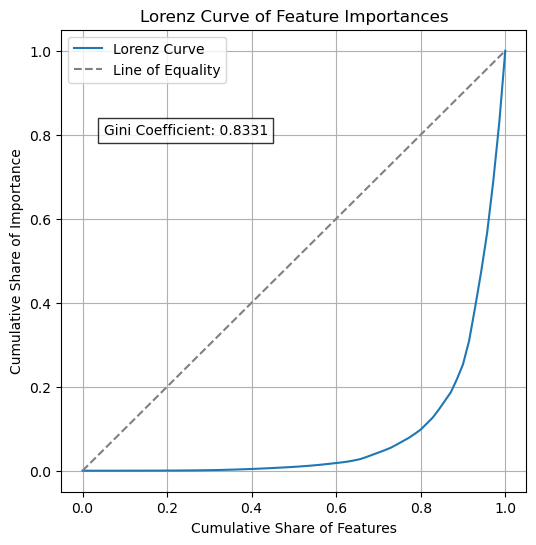

Top features (cover 80.0%):
 - 65 (importance = 0.1723)
 - 66 (importance = 0.1402)
 - 68 (importance = 0.1207)
 - 67 (importance = 0.0939)
 - 64 (importance = 0.0847)
 - 61 (importance = 0.0796)
 - 69 (importance = 0.0554)
 - 24 (importance = 0.0352)


{'summary_df':     importance  cumulative
 65    0.172310    0.172310
 66    0.140156    0.312466
 68    0.120687    0.433153
 67    0.093881    0.527034
 64    0.084670    0.611704
 ..         ...         ...
 36    0.000017    0.999954
 41    0.000014    0.999969
 33    0.000014    0.999983
 42    0.000009    0.999992
 50    0.000008    1.000000
 
 [70 rows x 2 columns],
 'top_features': [65, 66, 68, 67, 64, 61, 69, 24],
 'gini_coefficient': np.float64(0.8331028442900515)}

In [179]:
analyze_importance_distribution(feat_imp['importance'], threshold=0.8, plot=True, normalize=True)

In [180]:
important_indices = [66, 67, 68, 69, 65, 64]
X_train_subset = X_train.iloc[:, important_indices]

In [181]:
X_train_subset.head()

,propertysqft,latitude,longitude,bed_bath_ratio,bath,beds
0,0.000000,0.219838,1.903102,-0.550340,-0.584963,-1.356915
1,0.000000,1.357802,0.383686,-0.550340,-0.584963,-1.356915
2,0.000000,0.438858,1.513024,-0.550340,0.000000,-0.563171
3,-0.623029,-0.158930,0.808685,1.159172,-0.584963,0.000000
4,0.314607,0.018349,0.391071,0.159172,0.415037,0.793745


In [182]:
rf_final= RandomForestRegressor(n_estimators = 50, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_final.fit(X_train_subset, y_train)

RandomForestRegressor(max_depth=30, max_features='log2', n_estimators=50)

In [183]:
rf_final_pred = np.expm1(rf_final.predict(X_test.iloc[:, important_indices]))
rf_final_r2 = r2_score(original_y_test, rf_final_pred)
rf_final_mae = mean_absolute_error(original_y_test, rf_final_pred)
rf_final_mse = mean_squared_error(original_y_test, rf_final_pred)

In [184]:
pd.DataFrame({
    'R2': rf_final_r2,
    'MAE': rf_final_mae,
    'MSE': rf_final_mse,
    'RMSE': np.sqrt(rf_final_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.478099,787087.343288,1.314920e+13,3.626183e+06


In [185]:
rf_final_2 = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', max_depth = 30)
rf_final_2.fit(X_train_subset, y_train)
rf_final_pred_2 = np.expm1(rf_final_2.predict(X_test.iloc[:, important_indices]))

In [186]:
rf_final_2_r2 = r2_score(original_y_test, rf_final_pred_2)
rf_final_2_mae = mean_absolute_error(original_y_test, rf_final_pred_2)
rf_final_2_mse = mean_squared_error(original_y_test, rf_final_pred_2)
pd.DataFrame({
    'R2': rf_final_2_r2,
    'MAE': rf_final_2_mae,
    'MSE': rf_final_2_mse,
    'RMSE': np.sqrt(rf_final_2_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.490479,785847.00942,1.283730e+13,3.582918e+06


In [187]:
rf_final_3 = RandomForestRegressor(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 20)
rf_final_3.fit(X_train_subset, y_train)
rf_final_pred_3 = np.expm1(rf_final_2.predict(X_test.iloc[:, important_indices]))

In [188]:
rf_final_3_r2 = r2_score(original_y_test, rf_final_pred_3)
rf_final_3_mae = mean_absolute_error(original_y_test, rf_final_pred_3)
rf_final_3_mse = mean_squared_error(original_y_test, rf_final_pred_3)
pd.DataFrame({
    'R2': rf_final_3_r2,
    'MAE': rf_final_3_mae,
    'MSE': rf_final_3_mse,
    'RMSE': np.sqrt(rf_final_3_mse)
}, index=[0])

,R2,MAE,MSE,RMSE
0,0.490479,785847.00942,1.283730e+13,3.582918e+06


# 4. LGBM

In [191]:
lgbm_model = LGBMRegressor()
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20],
    'min_child_samples': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0]
}

In [192]:
lgbm_random_r2 = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='r2', n_iter=20)
lgbm_random_r2.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 70
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 69
[LightGBM

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='r2')

In [193]:
lgbm_random_mae = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='neg_mean_absolute_error', n_iter=20)
lgbm_random_mae.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 46
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_error')

In [194]:
lgbm_random_mse = RandomizedSearchCV(lgbm_model, lgbm_params, cv=kf, scoring='neg_mean_squared_error', n_iter=20)
lgbm_random_mse.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 49
[LightGBM] [Info] Start training from score 13.759746
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 3455, number of used features: 49
[LightGBM] [Info] Start training from score 13.751745
[LightGBM] [Warning] Found whi

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [None, 10, 20],
                                        'min_child_samples': [1, 5, 10],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_squared_error')

In [195]:
lbgm_r2_importance = lgbm_random_r2.best_estimator_.feature_importances_
lbgm_mae_importance = lgbm_random_mae.best_estimator_.feature_importances_ 
lbgm_mse_importance = lgbm_random_mse.best_estimator_.feature_importances_

C:\Users\Nobody\AppData\Local\Temp\ipykernel_14688\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


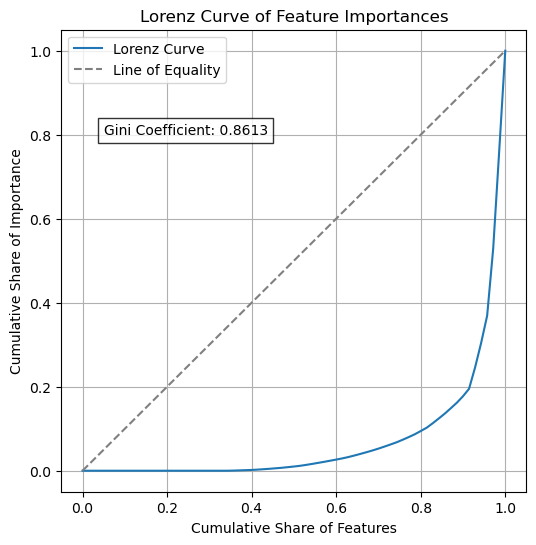

Top features (cover 80.0%):
 - 68 (importance = 0.2380)
 - 67 (importance = 0.2333)
 - 66 (importance = 0.1595)
 - 69 (importance = 0.0652)
 - 64 (importance = 0.0582)


{'summary_df':     importance  cumulative
 68    0.238000    0.238000
 67    0.233333    0.471333
 66    0.159500    0.630833
 69    0.065167    0.696000
 64    0.058167    0.754167
 ..         ...         ...
 42    0.000000    1.000000
 39    0.000000    1.000000
 38    0.000000    1.000000
 44    0.000000    1.000000
 45    0.000000    1.000000
 
 [70 rows x 2 columns],
 'top_features': [68, 67, 66, 69, 64],
 'gini_coefficient': np.float64(0.8613333333333333)}

In [196]:
lgbm_feature_names = X_train.columns
feat_imp_lgbm_r2 = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_r2_importance})

analyze_importance_distribution(feat_imp_lgbm_r2['importance'], threshold=0.8, plot=True, normalize=True)

C:\Users\Nobody\AppData\Local\Temp\ipykernel_14688\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


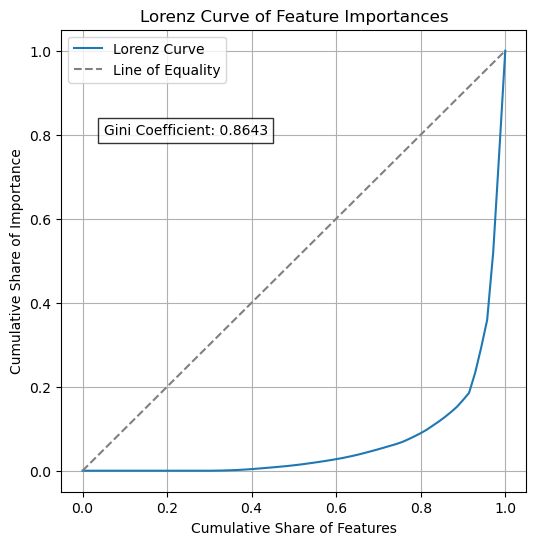

Top features (cover 80.0%):
 - 68 (importance = 0.2436)
 - 67 (importance = 0.2368)
 - 66 (importance = 0.1608)
 - 69 (importance = 0.0666)
 - 64 (importance = 0.0598)


{'summary_df':     importance  cumulative
 68    0.243556    0.243556
 67    0.236778    0.480333
 66    0.160778    0.641111
 69    0.066556    0.707667
 64    0.059778    0.767444
 ..         ...         ...
 41    0.000000    1.000000
 38    0.000000    1.000000
 46    0.000000    1.000000
 43    0.000000    1.000000
 45    0.000000    1.000000
 
 [70 rows x 2 columns],
 'top_features': [68, 67, 66, 69, 64],
 'gini_coefficient': np.float64(0.8642920634920634)}

In [197]:
feat_imp_lgbm_mae = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_mae_importance})

analyze_importance_distribution(feat_imp_lgbm_mae['importance'], threshold=0.8, plot=True, normalize=True)

C:\Users\Nobody\AppData\Local\Temp\ipykernel_14688\3681630074.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(lorenz_y, lorenz_x)


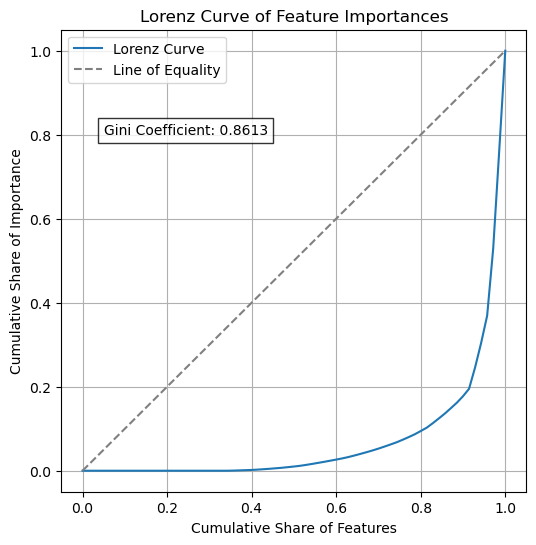

Top features (cover 80.0%):
 - 68 (importance = 0.2380)
 - 67 (importance = 0.2333)
 - 66 (importance = 0.1595)
 - 69 (importance = 0.0652)
 - 64 (importance = 0.0582)


{'summary_df':     importance  cumulative
 68    0.238000    0.238000
 67    0.233333    0.471333
 66    0.159500    0.630833
 69    0.065167    0.696000
 64    0.058167    0.754167
 ..         ...         ...
 42    0.000000    1.000000
 39    0.000000    1.000000
 38    0.000000    1.000000
 44    0.000000    1.000000
 45    0.000000    1.000000
 
 [70 rows x 2 columns],
 'top_features': [68, 67, 66, 69, 64],
 'gini_coefficient': np.float64(0.8613333333333333)}

In [198]:
feat_imp_lgbm_mse = pd.DataFrame({'feature': lgbm_feature_names, 'importance': lbgm_mse_importance})

analyze_importance_distribution(feat_imp_lgbm_mse['importance'], threshold=0.8, plot=True, normalize=True)

In [199]:
lgbm_X_train_subset = X_train.iloc[:, important_indices]
lgbm_X_test_subset = X_test.iloc[:, important_indices]

In [200]:
lgbm_random_best_model_r2 = lgbm_random_r2.best_params_
lgbm_random_best_model_mae = lgbm_random_mae.best_params_
lgbm_random_best_model_mse = lgbm_random_mse.best_params_

print("best model using r2 score",lgbm_random_best_model_r2)
print("best model using mae",lgbm_random_best_model_mae)    
print("best model using mse",lgbm_random_best_model_mse)

best model using r2 score {'subsample': 0.6, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': None, 'learning_rate': 0.1}
best model using mae {'subsample': 1.0, 'n_estimators': 300, 'min_child_samples': 5, 'max_depth': None, 'learning_rate': 0.1}
best model using mse {'subsample': 0.6, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': None, 'learning_rate': 0.1}


In [202]:
final_lgbm_model_1_r2 = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=0.6)
final_lgbm_model_1_r2.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=200,
              subsample=0.6)

In [203]:
final_lgbm_model_2_mae = LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=1)
final_lgbm_model_2_mae.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=300,
              subsample=1)

In [204]:
final_lgbm_model_3_mse = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=None, min_child_samples=5, subsample=0.6)
final_lgbm_model_3_mse.fit(lgbm_X_train_subset, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 3839, number of used features: 6
[LightGBM] [Info] Start training from score 13.754460


LGBMRegressor(max_depth=None, min_child_samples=5, n_estimators=200,
              subsample=0.6)

In [205]:
final_lgbm_pred_1_r2 = np.expm1(final_lgbm_model_1_r2.predict(lgbm_X_test_subset))
final_lgbm_pred_2_mae = np.expm1(final_lgbm_model_2_mae.predict(lgbm_X_test_subset))
final_lgbm_pred_3_mse = np.expm1(final_lgbm_model_3_mse.predict(lgbm_X_test_subset))

In [206]:
final_lgbm_1_r2_r2 = r2_score(original_y_test, final_lgbm_pred_1_r2)
final_lgbm_1_r2_mae = mean_absolute_error(original_y_test, final_lgbm_pred_1_r2)
final_lgbm_1_r2_mse = mean_squared_error(original_y_test, final_lgbm_pred_1_r2)

final_lgbm_2_mae_r2 = r2_score(original_y_test, final_lgbm_pred_2_mae)
final_lgbm_2_mae_mae = mean_absolute_error(original_y_test, final_lgbm_pred_2_mae)
final_lgbm_2_mae_mse = mean_squared_error(original_y_test, final_lgbm_pred_2_mae)

final_lgbm_3_mse_r2 = r2_score(original_y_test, final_lgbm_pred_3_mse)
final_lgbm_3_mse_mae = mean_absolute_error(original_y_test, final_lgbm_pred_3_mse)
final_lgbm_3_mse_mse = mean_squared_error(original_y_test, final_lgbm_pred_3_mse)

pd.DataFrame({
    'R2': [final_lgbm_1_r2_r2, final_lgbm_2_mae_r2, final_lgbm_3_mse_r2],
    'MAE': [final_lgbm_1_r2_mae, final_lgbm_2_mae_mae, final_lgbm_3_mse_mae],
    'MSE': [final_lgbm_1_r2_mse, final_lgbm_2_mae_mse, final_lgbm_3_mse_mse],
    'RMSE': [np.sqrt(final_lgbm_1_r2_mse), np.sqrt(final_lgbm_2_mae_mse), np.sqrt(final_lgbm_3_mse_mse)]
}, index=['LGBM Model 1 (R²)', 'LGBM Model 2 (MAE)', 'LGBM Model 3 (MSE)'])


,R2,MAE,MSE,RMSE
LGBM Model 1 (R²),0.556094,750866.467586,1.118414e+13,3.344270e+06
LGBM Model 2 (MAE),0.562504,743487.781833,1.102264e+13,3.320036e+06
LGBM Model 3 (MSE),0.556094,750866.467586,1.118414e+13,3.344270e+06


# 5. Save final model and column

In [208]:
joblib.dump(final_lgbm_model_2_mae, '..\\Model\\lgbm.pkl')

['..\\Model\\lgbm.pkl']

In [ ]:
joblib.dump(lgbm_X_train_subset, '..\\Model\\columns.pkl')

['columns.pkl']

In [210]:
lgbm_X_train_subset.columns

Index(['propertysqft', 'latitude', 'longitude', 'bed_bath_ratio', 'bath',
       'beds'],
      dtype='object')